In [107]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from tqdm import tqdm_notebook as tqdm
import matplotlib
from matplotlib import rcParams
import pandas as pd
from scipy import integrate, optimize
from scipy.stats import chi2, norm
import emcee
from iminuit import Minuit
import pymultinest
import corner

%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext Cython

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [108]:
# Set plotting options
rcParams['xtick.labelsize'] = 20
rcParams['ytick.labelsize'] = 20
rcParams['axes.labelsize'] = 20
rcParams['axes.titlesize'] = 20
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'CMU Serif'
rcParams['figure.figsize'] = (10/1.2,8/1.2)
rcParams['legend.fontsize'] = 16
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]


In [109]:
from NPTFit import nptfit # module for performing scan
from NPTFit import create_mask as cm # module for creating the mask
from NPTFit import psf_correction as pc # module for determining the PSF correction
from NPTFit import dnds_analysis # module for analysing the output

In [110]:
# eventclass = 5
# eventtype = 3
# data_dir = "/tigress/smsharma/Fermi-SmoothGalHalo/DataFiles/Bkg-Maps/fermi_data/eventclass"+str(eventclass)+"_eventtype"+str(eventtype)+"/"
# templates_dir = "/tigress/smsharma/Fermi-SmoothGalHalo/DataFiles/Bkg-Maps/templates_p6_full_ROI/"
# ebins = 2*np.logspace(-1,3,41)
# emin= 0
# emax = 39
# nbins = emax-emin+1
# nside = 128

In [111]:
# fermi_data_ebins = np.zeros((nbins,hp.nside2npix(nside)))
# fermi_exposure_ebins = np.zeros((nbins,hp.nside2npix(nside)))
# dif_ebins = np.zeros((nbins,hp.nside2npix(nside)))
# iso_ebins = np.zeros((nbins,hp.nside2npix(nside)))
# psc_ebins = np.zeros((nbins,hp.nside2npix(nside)))
# bub_ebins = np.zeros((nbins,hp.nside2npix(nside)))
# ps_mask_ebins = np.zeros((nbins,hp.nside2npix(nside)))

# for iebin in tqdm(range(nbins)):
#     fermi_data_ebins[iebin] = np.load(data_dir+"fermi_data_ebin_"+str(emin+iebin)+".npy")
#     fermi_exposure_ebins[iebin] = np.load(data_dir+"fermi_exposure_ebin_"+str(emin+iebin)+".npy")
#     dif_ebins[iebin] = np.load(temp+"dif_p6_ebin_"+str(emin+iebin)+".npy")
#     iso_ebins[iebin] = np.load(data_dir+"iso_ebin_"+str(emin+iebin)+".npy")
#     psc_ebins[iebin] = np.load(data_dir+"psc_ebin_"+str(emin+iebin)+".npy")
#     bub_ebins[iebin] = np.load(data_dir+"bub_ebin_"+str(emin+iebin)+".npy")
#     ps_mask_ebins[iebin] = np.load(data_dir+"psc_mask_0.95_ebin_"+str(emin+iebin)+".npy")

In [112]:
# dm_temp_ebins = np.zeros((nbins,hp.nside2npix(nside)))
# for iebin in range(nbins):
#     dm_temp_ebins[iebin] = np.load("/tigress/smsharma/Fermi-SmoothGalHalo/DataFiles/JfactorSmoothed/SmoothedBinned/SGH_Jfactor_map_NFW_"+str(emin+iebin)+".npy")
    

In [113]:
# dm_temp = np.sum(dm_temp_ebins[10:20,:],axis=0)

In [121]:
n = nptfit.NPTF()

In [122]:
fermi_data = np.load('fermi_data/fermidata_counts.npy').astype(np.int32)
fermi_exposure = np.load('fermi_data/fermidata_exposure.npy')
n.load_data(fermi_data, fermi_exposure)

In [123]:
analysis_mask = cm.make_mask_total(mask_ring = True, inner = 0, outer = 5, ring_b = 90, ring_l = 0)
n.load_mask(analysis_mask)

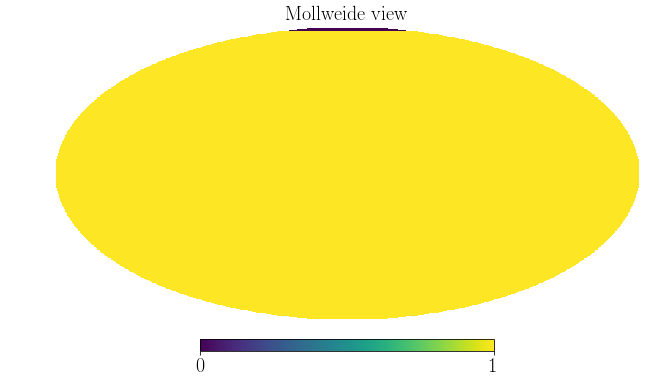

In [124]:
hp.mollview(analysis_mask)

In [125]:
iso_p = np.load('fermi_data/template_iso.npy')
n.add_template(iso_p, 'iso_p')
iso_np = np.ones(len(iso_p))
n.add_template(iso_np, 'iso_np',units='PS')

In [126]:
# analysis_mask = cm.make_mask_total(band_mask = True, band_mask_range = 2,
#                                    mask_ring = True, inner = 0, outer = 30,
#                                    custom_mask = ps_mask)
# hp.mollview(analysis_mask)

In [127]:
n.add_poiss_model('iso_p','$A_\mathrm{iso}$', False, fixed=True, fixed_norm=1.51)
n.add_non_poiss_model('iso_np',
                      ['$A^\mathrm{ps}_\mathrm{iso}$','$n_1$','$n_2$','$S_b$'],
                      [[-6,1],[2.05,30],[-2,1.95]],
                      [True,False,False],
                      fixed_params = [[3,172.52]])

In [128]:
pc_inst = pc.PSFCorrection(psf_sigma_deg=0.1812)
f_ary = pc_inst.f_ary
df_rho_div_f_ary = pc_inst.df_rho_div_f_ary

Loading the psf correction from: /tigress/ljchang/NPTF_test/psf_dir/gauss_128_0.181_10_50000_1000_0.01.npy


In [129]:
n.configure_for_scan(f_ary=f_ary, df_rho_div_f_ary=df_rho_div_f_ary)

The number of parameters to be fit is 3


In [130]:
n.perform_scan(nlive=500)

In [131]:
n.load_scan()

  analysing data from /tigress/ljchang/NPTF_test/chains/Untagged/.txt


In [147]:
np.loadtxt("/tigress/ljchang/NPTF_test/chains/Untagged/post_equal_weights.dat").shape

(1640, 4)

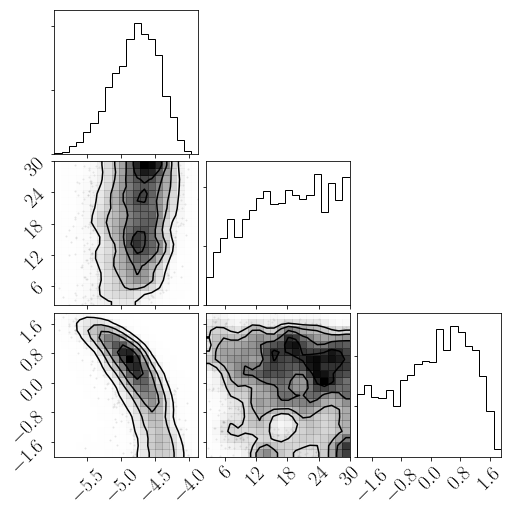

In [149]:
fig = corner.corner(np.loadtxt("/tigress/ljchang/NPTF_test/chains/Untagged/post_equal_weights.dat")[:,:3],smooth=1)

/tigress/ljchang/heptools/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:2961: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=172.52, right=172.52
  'left=%s, right=%s') % (left, right))
/tigress/ljchang/heptools/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3285: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=172.52, top=172.52
  'bottom=%s, top=%s') % (bottom, top))


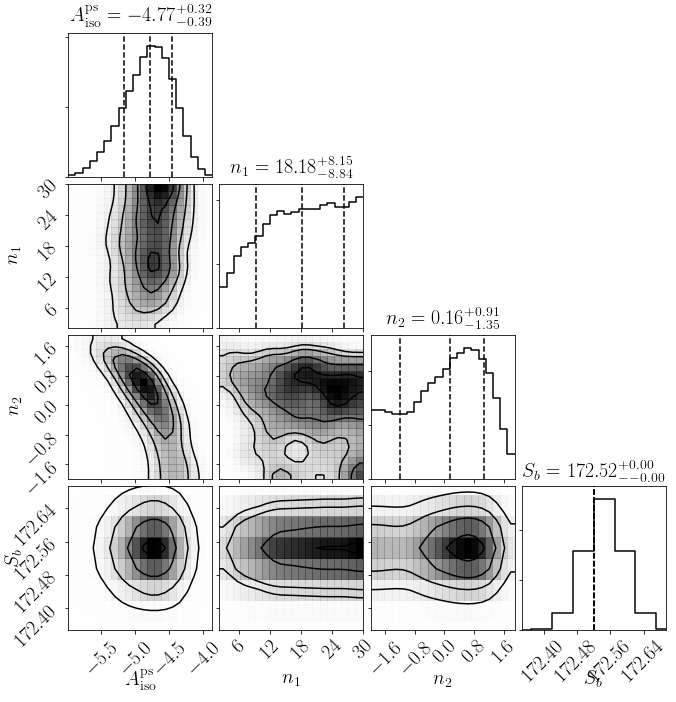

In [132]:
a = dnds_analysis.Analysis(n)
a.make_triangle()

Text(0.5,0,'$F$  [counts cm$^{-2}$ s$^{-1}$]')

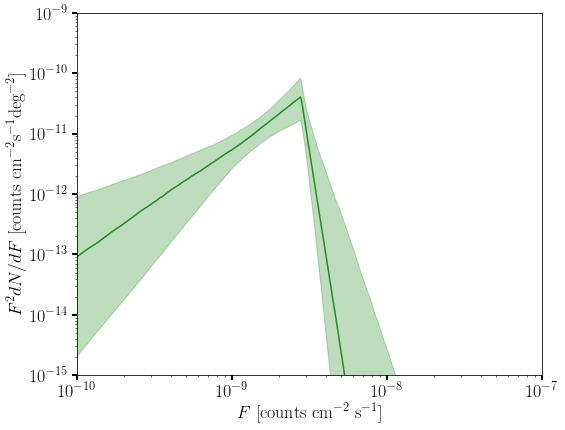

In [138]:
a.plot_source_count_median('iso_np',smin=0.01,smax=10000,nsteps=1000,spow=2,color='forestgreen')
a.plot_source_count_band('iso_np',smin=0.01,smax=10000,nsteps=1000,qs=[0.16,0.5,0.84],spow=2,color='forestgreen',alpha=0.3)

plt.yscale('log')
plt.xscale('log')
plt.xlim([1e-10,1e-7])
plt.ylim([1e-15,1e-9])
plt.tick_params(axis='x', length=5,width=2,labelsize=18)
plt.tick_params(axis='y',length=5,width=2,labelsize=18)
plt.ylabel('$F^2 dN/dF$ [counts cm$^{-2}$s$^{-1}$deg$^{-2}$]', fontsize=18)
plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]', fontsize=18)